<a href="https://colab.research.google.com/github/fockspaces/ML2021spring/blob/main/HW2%20Phoneme%20Classification/FC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework 2-1 Phoneme Classification**

* Slides: https://speech.ee.ntu.edu.tw/~hylee/ml/ml2021-course-data/hw/HW02/HW02.pdf
* Video (Chinese): https://youtu.be/PdjXnQbu2zo
* Video (English): https://youtu.be/ESRr-VCykBs


## The DARPA TIMIT Acoustic-Phonetic Continuous Speech Corpus (TIMIT)
The TIMIT corpus of reading speech has been designed to provide speech data for the acquisition of acoustic-phonetic knowledge and for the development and evaluation of automatic speech recognition systems.

This homework is a multiclass classification task, 
we are going to train a deep neural network classifier to predict the phonemes for each frame from the speech corpus TIMIT.

link: https://academictorrents.com/details/34e2b78745138186976cbc27939b1b34d18bd5b3

## Download Data
Download data from google drive, then unzip it.

You should have `timit_11/train_11.npy`, `timit_11/train_label_11.npy`, and `timit_11/test_11.npy` after running this block.<br><br>
`timit_11/`
- `train_11.npy`: training data<br>
- `train_label_11.npy`: training label<br>
- `test_11.npy`:  testing data<br><br>

**notes: if the google drive link is dead, you can download the data directly from Kaggle and upload it to the workspace**




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp "/content/drive/MyDrive/timit_11_v2.zip 的副本" "data.zip"
!unzip data.zip
!ls 

Archive:  data.zip
   creating: timit_11/
  inflating: timit_11/train_11.npy   
  inflating: timit_11/test_11.npy    
  inflating: timit_11/train_label_11.npy  
data.zip  drive  sample_data  timit_11


## Preparing Data
Load the training and testing data from the `.npy` file (NumPy array).

In [ ]:
import numpy as np

print('Loading data ...')

data_root='./timit_11/'
train = np.load(data_root + 'train_11.npy')
train_label = np.load(data_root + 'train_label_11.npy')
test = np.load(data_root + 'test_11.npy')

print('Size of training data: {}'.format(train.shape))
print('Size of testing data: {}'.format(test.shape))

Loading data ...
Size of training data: (1229932, 429)
Size of testing data: (451552, 429)


In [ ]:
from collections import Counter
counter = Counter(train_label)
for k,v in counter.items():
	per = v / len(train_label) * 100
	print('Class=%s, Count=%d, Percentage=%.3f%%' % (k, v, per))

Class=36, Count=27088, Percentage=2.202%
Class=1, Count=83746, Percentage=6.809%
Class=37, Count=14164, Percentage=1.152%
Class=2, Count=35048, Percentage=2.850%
Class=38, Count=178713, Percentage=14.530%
Class=22, Count=7050, Percentage=0.573%
Class=25, Count=8219, Percentage=0.668%
Class=4, Count=38930, Percentage=3.165%
Class=30, Count=25094, Percentage=2.040%
Class=35, Count=84521, Percentage=6.872%
Class=5, Count=26380, Percentage=2.145%
Class=19, Count=47059, Percentage=3.826%
Class=27, Count=6059, Percentage=0.493%
Class=14, Count=39583, Percentage=3.218%
Class=16, Count=20922, Percentage=1.701%
Class=7, Count=73827, Percentage=6.003%
Class=26, Count=7825, Percentage=0.636%
Class=17, Count=51533, Percentage=4.190%
Class=13, Count=43410, Percentage=3.529%
Class=15, Count=11342, Percentage=0.922%
Class=6, Count=4038, Percentage=0.328%
Class=3, Count=59031, Percentage=4.800%
Class=18, Count=24938, Percentage=2.028%
Class=10, Count=11028, Percentage=0.897%
Class=23, Count=10663, Per

In [ ]:
import pandas as pd
df = pd.read_csv("/content/distribution.csv")
df['count'] = df['count'] / 1000
df.head()

,id,count
0,0,62.708
1,1,83.746
2,2,35.048
3,3,59.031
4,4,38.930


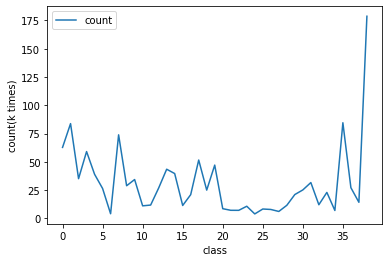

In [ ]:
import matplotlib.pyplot as plt
df.plot(x="id", y="count")
plt.xlabel('class')
plt.ylabel('count(k times)')
plt.show()

In [ ]:
def sample(data, stride):
  base = data.copy()
  for step in range(1, stride+1, 1):
    Rshift = np.roll(base,step,axis=0)
    data = np.concatenate((Rshift,data), axis=1)
  for step in range(-1, -1-1*stride, -1):
    Lshift = np.roll(base,step,axis=0)
    data = np.concatenate((data,Lshift), axis=1)

  data = np.reshape(data, (-1,2*stride+1,39))
  return data

def normalize(data):
  mean = np.mean(data, axis=0)
  std = np.std(data, axis=0)
  return (data - mean)/std

In [ ]:
stride = 10
# (,429)split to(11,39)
train = np.reshape(train, (-1,11,39))
test = np.reshape(test, (-1,11,39))

# pick only the 5th MFCC which is corresponding to label
train = train[:,5,:]
test = test[:,5,:]

# include nearby MFCC (To extend the frame length)
train = sample(train, stride)
test = sample(test, stride)

# flatten to (-1,39*n)
train = np.reshape(train, (-1,(2*stride+1)*39))
test = np.reshape(test, (-1,(2*stride+1)*39))

# normalize data
# train = normalize(train)
# test = normalize(test)

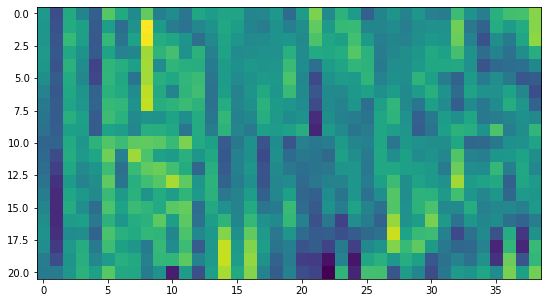

In [ ]:
import matplotlib.pyplot as plt
mfcc = np.reshape(train[0], ((2*stride+1),39))
fig, ax = plt.subplots(figsize=(15, 5))
ax.imshow(mfcc);

## Create Dataset

In [ ]:
import torch
from torch.utils.data import Dataset

class TIMITDataset(Dataset):
    def __init__(self, X, y=None):
        self.data = torch.from_numpy(X).float()
        if y is not None:
            y = y.astype(np.int)
            self.label = torch.LongTensor(y)
        else:
            self.label = None

    def __getitem__(self, idx):
        if self.label is not None:
            return self.data[idx], self.label[idx]
        else:
            return self.data[idx]

    def __len__(self):
        return len(self.data)


Split the labeled data into a training set and a validation set, you can modify the variable `VAL_RATIO` to change the ratio of validation data.

In [ ]:
VAL_RATIO = 0

percent = int(train.shape[0] * (1 - VAL_RATIO))
train_x, train_y, val_x, val_y = train[:percent], train_label[:percent], train[percent:], train_label[percent:]
print('Size of training set: {}'.format(train_x.shape))
print('Size of validation set: {}'.format(val_x.shape))

Size of training set: (1229932, 819)
Size of validation set: (0, 819)


Create a data loader from the dataset, feel free to tweak the variable `BATCH_SIZE` here.

In [ ]:
BATCH_SIZE = 1024

from torch.utils.data import DataLoader

train_set = TIMITDataset(train_x, train_y)
val_set = TIMITDataset(val_x, val_y)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True) #only shuffle the training data
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


Cleanup the unneeded variables to save memory.<br>

**notes: if you need to use these variables later, then you may remove this block or clean up unneeded variables later<br>the data size is quite huge, so be aware of memory usage in colab**

In [ ]:
import gc

del train, train_label, train_x, train_y, val_x, val_y
gc.collect()

2838

## Create Model

Define model architecture, you are encouraged to change and experiment with the model architecture.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.net = nn.Sequential(
        #1
        nn.Linear((2*stride+1)*39, 1024),
        nn.BatchNorm1d(1024),
        nn.Dropout(0.25),
        nn.ReLU(),
        #2
        nn.Linear(1024, 2048),
        nn.BatchNorm1d(2048),
        nn.Dropout(0.25),
        nn.ReLU(),
        #3
        nn.Linear(2048, 2048),
        nn.BatchNorm1d(2048),
        nn.Dropout(0.25),
        nn.ReLU(),
        #4
        nn.Linear(2048, 1024),
        nn.BatchNorm1d(1024),
        nn.Dropout(0.25),
        nn.ReLU(),
        #5
        nn.Linear(1024, 512),
        nn.BatchNorm1d(512),
        nn.Dropout(0.5),
        nn.ReLU(),
        #6
        nn.Linear(512, 128),
        nn.BatchNorm1d(128),
        nn.Dropout(0.5),
        nn.ReLU(),
        
        #7
        nn.Linear(128, 39)
        )
        

    def forward(self, x):
        x = self.net(x)
        x = F.log_softmax(x, dim=1)
        return x

## Training

In [ ]:
#check device
def get_device():
  return 'cuda' if torch.cuda.is_available() else 'cpu'

Fix random seeds for reproducibility.

In [ ]:
# fix random seed
def same_seeds(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  
    np.random.seed(seed)  
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

Feel free to change the training parameters here.

In [ ]:
# fix random seed for reproducibility
same_seeds(0)

# get device 
device = get_device()
print(f'DEVICE: {device}')

# training parameters
num_epoch = 500               # number of training epoch
learning_rate = 1e-4       # learning rate
l2 = 0
# the path where checkpoint saved
model_path = './modelFC500.ckpt'

# create model, define a loss function, and optimizer
model = Classifier().to(device)
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2)

DEVICE: cuda


In [ ]:
#@title 預設標題文字
# start training

best_acc = 0.0
Total_loss = []
Total_acc = []
for epoch in range(num_epoch):
    #switch optimizer
    if epoch == 0:
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    elif epoch == 35:
            optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    train_acc = 0.0
    train_loss = 0.0
    val_acc = 0.0
    val_loss = 0.0
    # training
    model.train() # set the model to training mode
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad() 
        outputs = model(inputs) 
        batch_loss = criterion(outputs, labels)
        _, train_pred = torch.max(outputs, 1) # get the index of the class with the highest probability
        batch_loss.backward() 
        optimizer.step() 

        train_acc += (train_pred.cpu() == labels.cpu()).sum().item()
        train_loss += batch_loss.item()
        

    # validation
    if len(val_set) > 0:
        model.eval() # set the model to evaluation mode
        with torch.no_grad():
            for i, data in enumerate(val_loader):
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                batch_loss = criterion(outputs, labels) 
                _, val_pred = torch.max(outputs, 1) 
            
                val_acc += (val_pred.cpu() == labels.cpu()).sum().item() # get the index of the class with the highest probability
                val_loss += batch_loss.item()

            print('[{:03d}/{:03d}] Train Acc: {:3.6f} Loss: {:3.6f} | Val Acc: {:3.6f} loss: {:3.6f}'.format(
                epoch + 1, num_epoch, train_acc/len(train_set), train_loss/len(train_loader), val_acc/len(val_set), val_loss/len(val_loader)
            ))

            # if the model improves, save a checkpoint at this epoch
            if val_acc > best_acc:
                best_acc = val_acc
                torch.save(model.state_dict(), model_path)
                print('saving model with acc {:.3f}'.format(best_acc/len(val_set)))
    else:
        Total_acc.append(train_acc/len(train_set))
        Total_loss.append(train_loss/len(train_loader))
        print('[{:03d}/{:03d}] Train Acc: {:3.6f} Loss: {:3.6f}'.format(
            epoch + 1, num_epoch, train_acc/len(train_set), train_loss/len(train_loader)
        ))

# if not validating, save the last epoch
if len(val_set) == 0:
    torch.save(model.state_dict(), model_path)
    print('saving model at last epoch')


[001/500] Train Acc: 0.535228 Loss: 1.715134
[002/500] Train Acc: 0.646056 Loss: 1.188643
[003/500] Train Acc: 0.675237 Loss: 1.065965
[004/500] Train Acc: 0.692072 Loss: 0.996616
[005/500] Train Acc: 0.704595 Loss: 0.946775
[006/500] Train Acc: 0.714633 Loss: 0.908811
[007/500] Train Acc: 0.723429 Loss: 0.875645
[008/500] Train Acc: 0.731414 Loss: 0.846844
[009/500] Train Acc: 0.737714 Loss: 0.821320
[010/500] Train Acc: 0.744191 Loss: 0.799039
[011/500] Train Acc: 0.749611 Loss: 0.778237
[012/500] Train Acc: 0.755025 Loss: 0.758474
[013/500] Train Acc: 0.759439 Loss: 0.740999
[014/500] Train Acc: 0.764015 Loss: 0.724654
[015/500] Train Acc: 0.769160 Loss: 0.708131
[016/500] Train Acc: 0.773448 Loss: 0.692463
[017/500] Train Acc: 0.777413 Loss: 0.677960
[018/500] Train Acc: 0.780955 Loss: 0.665351
[019/500] Train Acc: 0.785634 Loss: 0.651259
[020/500] Train Acc: 0.788781 Loss: 0.638338
[021/500] Train Acc: 0.792417 Loss: 0.625361
[022/500] Train Acc: 0.795376 Loss: 0.615316
[023/500] 

## Testing

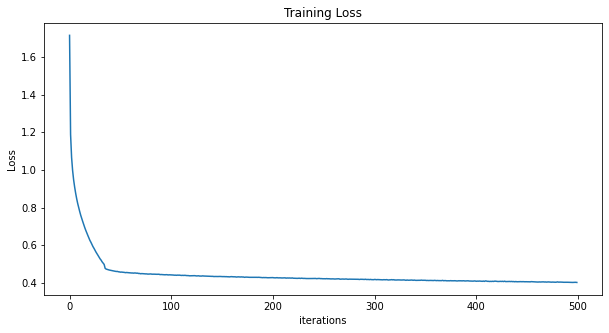

In [ ]:
plt.figure(figsize=(10,5)) 
plt.title("Training Loss")
plt.plot(Total_loss)
plt.xlabel("iterations")
plt.ylabel("Loss")
# plt.legend()
plt.show()

In [ ]:
plt.savefig('loss.png')

<Figure size 432x288 with 0 Axes>

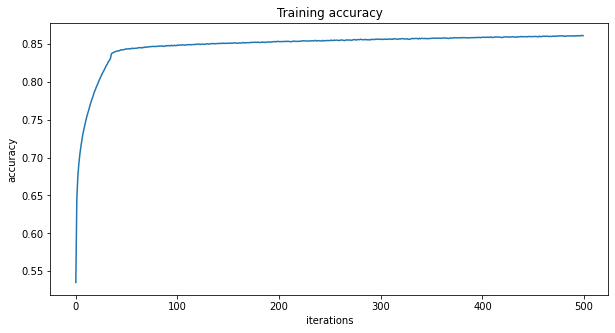

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Training accuracy")
plt.plot(Total_acc)
plt.xlabel("iterations")
plt.ylabel("accuracy")
# plt.legend()
plt.show()

In [ ]:
plt.savefig('accuracy.png')

<Figure size 432x288 with 0 Axes>

In [ ]:
from google.colab import files
!cp -r "/content/modelFC500.ckpt" "/content/drive/MyDrive/"
# files.download("modelFC500.ckpt")

Create a testing dataset, and load model from the saved checkpoint.

In [ ]:
# create testing dataset
test_set = TIMITDataset(test, None)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

# create model and load weights from checkpoint
model = Classifier().to(device)
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

Make prediction.

In [ ]:
predict = []
model.eval() # set the model to evaluation mode
with torch.no_grad():
    for i, data in enumerate(test_loader):
        inputs = data
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, test_pred = torch.max(outputs, 1) # get the index of the class with the highest probability

        for y in test_pred.cpu().numpy():
            predict.append(y)

In [ ]:
count = 0
for i in range(1, len(predict)-1):
    step = 1
    previous_ = predict[i-step]
    next_ = predict[i+step]
    current_ = predict[i]
    if (previous_ != current_) and (next_ != current_) and (previous_ == next_):
        print('idx',i,'correct', current_, 'to', previous_)
        predict[i] = previous_
        count +=1

print('total number of correction %d, correction percent %.2f'% (count, count/len(predict)))

for i in range(1, len(predict)-1):
    step = 2
    if i == 1 or i == len(predict)-2: step = 1
    previous_ = predict[i-step]
    next_ = predict[i+step]
    current_ = predict[i]
    if (previous_ != current_) and (next_ != current_) and (previous_ == next_):
        print('idx',i,'correct', current_, 'to', previous_)
        predict[i] = previous_
        count +=1

print('total number of correction %d, correction percent %.2f'% (count, count/len(predict)))



Streaming output truncated to the last 5000 lines.
idx 215821 correct 6 to 13
idx 216143 correct 1 to 0
idx 216314 correct 38 to 35
idx 216662 correct 2 to 1
idx 216694 correct 33 to 34
idx 216737 correct 7 to 10
idx 216869 correct 38 to 26
idx 217008 correct 4 to 2
idx 217110 correct 5 to 0
idx 217216 correct 17 to 7
idx 217243 correct 12 to 10
idx 217352 correct 9 to 3
idx 217604 correct 1 to 0
idx 217727 correct 38 to 35
idx 218169 correct 30 to 38
idx 218339 correct 30 to 38
idx 218408 correct 2 to 12
idx 218415 correct 12 to 13
idx 218529 correct 1 to 0
idx 218644 correct 35 to 29
idx 218924 correct 4 to 2
idx 219021 correct 1 to 9
idx 219583 correct 34 to 38
idx 220053 correct 4 to 1
idx 220333 correct 7 to 4
idx 220460 correct 29 to 38
idx 220471 correct 19 to 38
idx 221019 correct 14 to 17
idx 221062 correct 30 to 29
idx 221462 correct 1 to 2
idx 221602 correct 1 to 0
idx 221698 correct 1 to 2
idx 221753 correct 36 to 21
idx 221842 correct 16 to 7
idx 222213 correct 17 to 14
id

Write prediction to a CSV file.

After finish running this block, download the file `prediction.csv` from the files section on the left-hand side and submit it to Kaggle.

In [ ]:
with open('predictionFC500.csv', 'w') as f:
    f.write('Id,Class\n')
    for i, y in enumerate(predict):
        f.write('{},{}\n'.format(i, y))

In [ ]:
!cp -r "/content/predictionFC500.csv" "/content/drive/MyDrive/"
files.download("predictionFC500.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!cp -r "/content/accuracy.png" "/content/drive/MyDrive/"
!cp -r "/content/loss.png'" "/content/drive/MyDrive/"

cp: cannot stat "/content/loss.png'": No such file or directory
